In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GMM
from scipy.stats import norm
from matplotlib.patches import Ellipse

from astroML.datasets import fetch_sdss_sspp
from astroML.decorators import pickle_results
from astroML.plotting.tools import draw_ellipse

from thesis_code import fits

@pickle_results: using precomputed results from 'GMM_metallicity.pkl'
best fit converged: True
BIC: n_components =  7


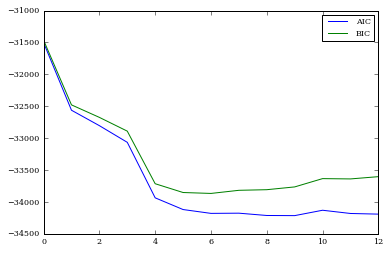

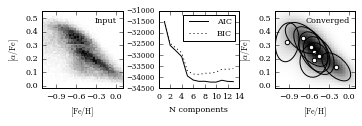

In [26]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general


#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Get the Segue Stellar Parameters Pipeline data
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

#------------------------------------------------------------
# Compute GMM models & AIC/BIC
N = np.arange(1, 14)


@pickle_results("GMM_metallicity.pkl")
def compute_GMM(N, covariance_type='full', n_iter=1000):
    models = [None for n in N]
    for i in range(len(N)):
        print N[i]
        models[i] = GMM(n_components=N[i], n_iter=n_iter,
                        covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GMM(N)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print "best fit converged:", gmm_best.converged_
print "BIC: n_components =  %i" % N[i_best]

for name,criteria in zip(['AIC','BIC'],[AIC,BIC]):
    plt.plot(range(len(criteria)),criteria,label=name)
plt.legend(loc='upper right')

#------------------------------------------------------------
# compute 2D density
FeH_bins = 51
alphFe_bins = 51
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'],
                                          (FeH_bins, alphFe_bins))

Xgrid = np.array(map(np.ravel,
                     np.meshgrid(0.5 * (FeH_bins[:-1]
                                        + FeH_bins[1:]),
                                 0.5 * (alphFe_bins[:-1]
                                        + alphFe_bins[1:])))).T
log_dens = gmm_best.score(Xgrid).reshape((51, 51))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 1.66))
fig.subplots_adjust(wspace=0.45,
                    bottom=0.25, top=0.9,
                    left=0.1, right=0.97)

# plot density
ax = fig.add_subplot(131)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.text(0.93, 0.93, "Input",
        va='top', ha='right', transform=ax.transAxes)

# plot AIC/BIC
ax = fig.add_subplot(132)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, ':k', label='BIC')
ax.legend(loc=1)
ax.set_xlabel('N components')
plt.setp(ax.get_yticklabels(), fontsize=7)

# plot best configurations for AIC and BIC
ax = fig.add_subplot(133)
ax.imshow(np.exp(log_dens),
          origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

ax.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for mu, C, w in zip(gmm_best.means_, gmm_best.covars_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax, fc='none', ec='k')

ax.text(0.93, 0.93, "Converged",
        va='top', ha='right', transform=ax.transAxes)

ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

# plt.show()

cnt=0, wt= 0.0994021722224
cnt=1, wt= 0.0687640868872
cnt=2, wt= 0.171508625603
cnt=3, wt= 0.222012059802
cnt=4, wt= 0.130576895548
cnt=5, wt= 0.201206543691
cnt=6, wt= 0.106529616246


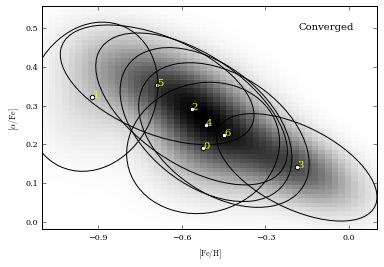

In [24]:
# plot best configurations for AIC and BIC
fig,ax=plt.subplots()
ax.imshow(np.exp(log_dens),
          origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

ax.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
scale=2.
cnt=0
for mu, C, w in zip(gmm_best.means_, gmm_best.covars_, gmm_best.weights_):
    print 'cnt=%d, wt=' % cnt,w
#     draw_ellipse(mu, C, scales=[1.5], ax=ax, fc='none', ec='k')
    # Draw MoG outlines
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                         (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    ax.text(mu[0],mu[1],str(cnt),color='yellow')
    ax.add_patch(Ellipse((mu[0], mu[1]),
                 2 * scale * sigma1, 2 * scale * sigma2,
                 alpha * 180. / np.pi,\
                 fc='none', ec='k'))
    cnt+=1

ax.text(0.93, 0.93, "Converged",
        va='top', ha='right', transform=ax.transAxes)

ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

In [21]:
def sample(self, n_samples=1, random_state=None):
    if self.covtype != 'full':
        return NotImplementedError(
            'covariance type "{0}" not implemented yet.'.format(self.covtype))

    # Code adapted from sklearn's GMM.sample()
    if random_state is None:
        random_state = np.random.RandomState()

    weight_cdf = np.cumsum(self.weights)
    X = np.empty((n_samples, self.n_dimensions))
    rand = random_state.rand(n_samples)
    # decide which component to use for each sample
    comps = weight_cdf.searchsorted(rand)
    # for each component, generate all needed samples
    for comp in range(self.n_components):
        # occurrences of current component in X
        comp_in_X = (comp == comps)
        # number of those occurrences
        num_comp_in_X = comp_in_X.sum()
        if num_comp_in_X > 0:
            X[comp_in_X] = random_state.multivariate_normal(
                self.means[comp], self.covars[comp], num_comp_in_X)
    return X

In [33]:
weight_cdf= np.cumsum(gmm_best.weights_)
randsd=np.random.RandomState()
rand = randsd.rand(10)
# decide which component to use for each sample
result= weight_cdf.searchsorted(rand)
print weight_cdf
print rand
print result

[ 0.09940217  0.16816626  0.33967488  0.56168694  0.69226384  0.89347038
  1.        ]
[ 0.33716436  0.88063326  0.99200097  0.04095968  0.90151202  0.5606042
  0.49451773  0.38379037  0.76564743  0.34569735]
[2 5 6 0 6 3 3 3 5 3]


In [34]:
import os
a='MoG.ipynb'
base=os.path.basename(a).replace('.ipynb','')
base

'MoG'

In [41]:
a=['hello']*6
''.join([b + '_' for b in a])

'hello_hello_hello_hello_hello_hello_'

In [6]:
trac=fits.load('decals-dr2-deep2-field2.fits.gz')
deep=fits.load('deep2-field2.fits.gz')

In [2]:
deep1= fits.load('deep2egs-oii.fits.gz')

In [3]:
len(deep1)

8321

In [57]:
def fx(x,name,bnds):
    if name == 'y1': return 1.15*x-0.15
    elif name == 'y2': return -1.2*x+1.6
    else: raise ValueError
    
def fx_diff(x,name,bnds):
    if name == 'y1-y2': return fx(x,'y1',bnds)-fx(x,'y2',bnds)
    else: raise ValueError
    
#     if name == 'y2-y1':
#         return -1+2.*x
#     else: raise ValueError
#     grrange = (-0.3,2.0)
#     rzrange = (-0.5,2.1)
# #     x=np.linspace(rzrange[0],rzrange[1],num=100)
#     y=np.linspace(grrange[0],grrange[1],num=len(x))
#     x1,y1= x,1.15*x-0.15
#     x2,y2= [0.3]*len(x),y
#     return y2-y1
from scipy.optimize import brentq, newton
from scipy.optimize import minimize, rosen, rosen_der
# x0 = [0]
# res = minimize(fx, x0, method='Nelder-Mead',bounds=tuple((-1,2))) #, tol=1e-6)
# if not res.success: print "minimization failed: %s" % res.message
# print newton(fx,-1,args=('y2-y1',))

In [58]:
print newton(fx_diff,np.array([1.]),args=('y1-y2',[-0.3,2.0]))

[ 0.74468085]


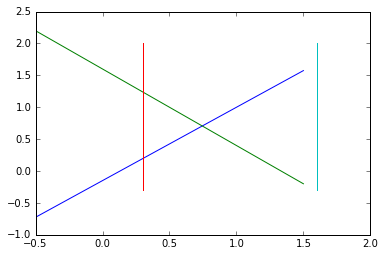

In [49]:
x=np.arange(-0.5,2.1)
plt.plot(x,fx(x,'y1',[-0.3,2.0]))
plt.plot(x,fx(x,'y3',[-0.3,2.0]))
x=[0.3]*2
plt.plot(x,fx(x,'y2',[-0.3,2.0]))
x=[01.6]*2
plt.plot(x,fx(x,'y4',[-0.3,2.0]))
    

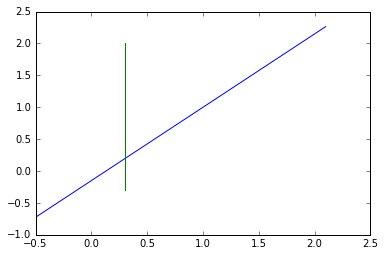

In [19]:
grrange = (-0.3,2.0)
rzrange = (-0.5,2.1)
x=np.linspace(rzrange[0],rzrange[1],num=100)
y=np.linspace(grrange[0],grrange[1],num=100)
x1,y1= x,1.15*x-0.15
x2,y2= [0.3]*len(x),y
plt.plot(x1,y1)
plt.plot(x2,y2)